In [1]:
from PIL import Image
import json
import torchvision.transforms.functional as TF
import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src.detector.utils import binary_mask_iou
from src.detector.utils import box_nms, mask_nms
from src.tracker.data_track_precomputed import MOT16SequencesPrecomputed
from src.utils.torch_utils import dict2keys_and_items
from src.detector.visualize import visualize_detection
from src.detector.object_detector import init_detector
from src.detector.data_obj_detect import MOT16ObjDetect
from src.detector.utils import obj_detect_transforms

root = "data/MOT16"
split = "mini"
det1_path = "data/precomputed_detection/coco_maskrcnn100"
det2_path = "data/precomputed_detection/coco_maskrcnn100_masknms20"

det1_sequences = MOT16SequencesPrecomputed(
        precomputed_data_root_dir=det1_path,
        original_data_root_dir=root,
        split=split,
        vis_threshold=-1,
        return_det_segmentation=True
)
det2_sequences = MOT16SequencesPrecomputed(
        precomputed_data_root_dir=det2_path,
        original_data_root_dir=root,
        split=split,
        vis_threshold=-1,
        return_det_segmentation=True
)
dataset_test = MOT16ObjDetect(
        root=root,
        split=split,
        transforms=obj_detect_transforms(train=False),
        vis_threshold=-1,
        segmentation=False,
    )


In [2]:
results1 = det1_sequences.get_detection_results_dict()
results2 = det2_sequences.get_detection_results_dict()

compare_dict = dataset_test.compare_detectors(results1, results2)

In [69]:
# NMS 100% ohne maskNMS hat eine extra true positives weil
# - weil wenn mehrere boxen auf ein objekt spammen, dann wird das hinterliegende object automatisch mit erwischt, auch wenn es ar nicht sichtbar ist
# - durch mehr erlaubte boxen steigt die wahrscheinlichkeit, dass eine box mehr als 0.5 overlap hat. Sonst evtl 0.47 overlap oderso. Manchmal hat die box geringerem score höheren overlap
# - wenn occluded verschätzt sich der detector um die shape der box, auch wenn er das object erkennt
# - wenn es zu dunkel ist verschätzt sich detector auch um die shape (füße cutoff z.B.), obwohl sie nicht verdeckt sind
# - nms strenger machen auf ca 80, sonst wird die group size durch identische proposals vollgestopft. oder group size erhöhen aber das wird rechenteuer
# - masknms lockern auf ca 30-50%, wenns dunkel ist schreibt der detector die fläche ziwschen zwei objekten ist beiden objekten zu

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

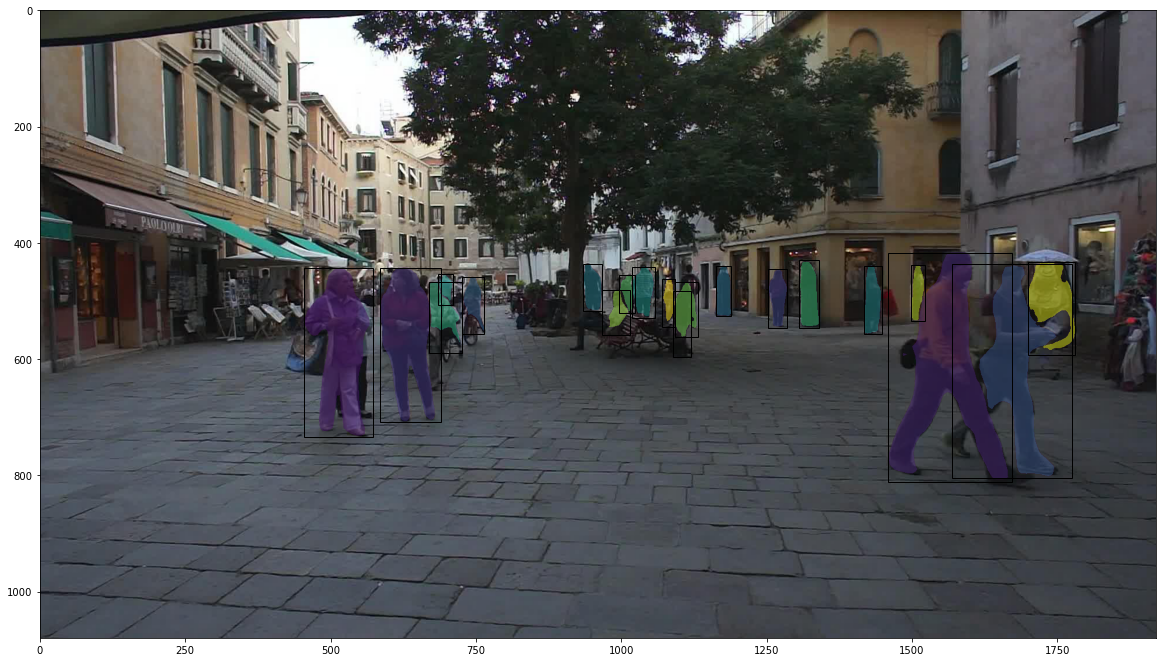

In [67]:
frame_id = 20
det2_sequence = det2_sequences[0]
det2_frame = det2_sequence[frame_id-1]
det1_sequence = det1_sequences[0]
det1_frame = det1_sequence[frame_id-1]

gt_boxes = torch.stack(list(det2_frame["gt"].values()), dim=0)
det1_boxes = det1_frame["boxes"]
det2_boxes = det2_frame["boxes"]


visualize_detection(det2_frame["img"], torch.cat([gt_boxes[[4]], det2_boxes], dim=0), masks=det2_frame["masks"])

In [6]:
import torch

torch.load("models/reid_model/default_reid/model.pth")

AttributeError: 'ResNet' object has no attribute 'input_is_masked'